In [ ]:
# preparing notebook for visualization purposes
# (only show outputs between t=180s and t=240s)
from pyannote.core import notebook, Segment
notebook.crop = Segment(210, 240)

# Training, fine-tuning, and transfer learning with `pyannote.audio`

In this tutorial, you will learn how to use `pyannote.audio` to 

* train a voice activity detection model from scratch, 
* fine-tune a pretrained speaker segmentation model,
* perform transfer learning (from speaker segmentation to overlapped speech detection)

## Data preparation

This tutorial assumes that 
* the [AMI corpus](https://groups.inf.ed.ac.uk/ami/corpus/) has already been [setup for use with `pyannote`](https://github.com/pyannote/AMI-diarization-setup/tree/main/pyannote)
* the `PYANNOTE_DATABASE_CONFIG` environment variable is set accordingly. 

See [`pyannote.database` documentation](https://github.com/pyannote/pyannote-database#pyannote-database) to learn how to prepare your own dataset for training with `pyannote.audio`.

In [ ]:
from pyannote.database import get_protocol
ami = get_protocol('AMI.SpeakerDiarization.only_words')

## Training a voice activity detection model from scratch

Voice activity detection (VAD) is the task of detecting speech regions in a given audio stream or recording.

We initialize a VAD *task* that describes how the model will be trained:

* `ami` indicates that we will use files available in `ami.train()`.
* `duration=2.` and `batch_size=128` indicates that the model will ingest batches of 128 two seconds long audio chunks.

In [ ]:
from pyannote.audio.tasks import VoiceActivityDetection
vad_task = VoiceActivityDetection(ami, duration=2.0, batch_size=128)

We initialize one *model* with the `PyanNet` architecture used [in that paper](https://arxiv.org/abs/2104.04045).  
In particular, we increase the default stride of the initial `sincnet` feature extraction layer to `10`.

The model is also provided with the task (`task=vad_task`) for which it is being trained:

In [ ]:
from pyannote.audio.models.segmentation import PyanNet
vad_model = PyanNet(task=vad_task, sincnet={'stride': 10})

Now that everything is ready, let's train with `pytorch-ligthning`!

In [ ]:
import pytorch_lightning as pl
trainer = pl.Trainer(gpus=1, max_epochs=1)
trainer.fit(vad_model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params | In sizes        | Out sizes                                        
-----------------------------------------------------------------------------------------------------------------------
0 | sincnet           | SincNet    | 42.6 K | [128, 1, 32000] | [128, 60, 115]                                   
1 | lstm              | LSTM       | 589 K  | [128, 115, 60]  | [[128, 115, 256], [[4, 128, 128], [4, 128, 128]]]
2 | linear            | ModuleList | 49.4 K | ?               | ?                                                
3 | classifier        | Linear     | 129    | [128, 115, 128] | [128, 115, 1]                                    
4 | activation        | Sigmoid    | 0      | [128, 115, 1]   | [128, 115, 1]                                    
5 | validation_metric | AUROC      | 0      

For the purpose of this tutorial, the model is trained for only 1 epoch. One can obviously expect better performance by training longer and on more data.

See [`pytorch-lightning`](https://www.pytorchlightning.ai/) documentation to learn more about the [`Trainer` API](https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html), in particular.

Once trained, the model can be applied to a test file:

In [ ]:
test_file = next(ami.test())
# here we use a test file provided by the protocol, but it could be any audio file
# e.g. test_file = "/path/to/test.wav".

Because the model was trained on 2s audio chunks and that test files are likely to be much longer than that, we wrap the `model` with an `Inference` instance: it will take care of sliding a 2s window over the whole file and aggregate the output of the model.

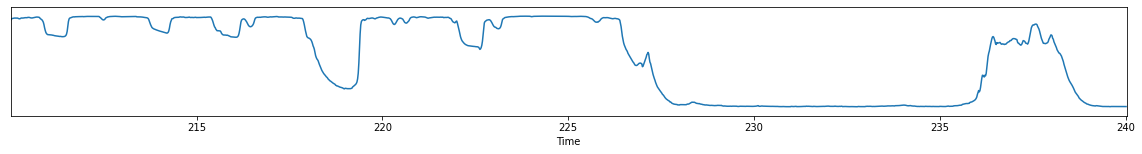

In [ ]:
from pyannote.audio import Inference
vad = Inference(vad_model)

vad_probability = vad(test_file)
vad_probability

Perfect voice activity detection output should look like that:

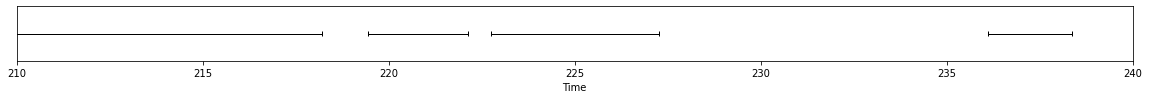

In [ ]:
expected_output = test_file["annotation"].get_timeline().support()
expected_output

## Fine-tuning a pretrained speaker segmentation model

Speaker diarization is the task of partitioning a given audio stream of recording into according to the speaker identity.

[`pyannote/segmentation`](https://hf.co/pyannote/segmentation) is a model that was pretrained to perform speaker diarization, but only locally, on 5s-long audio chunks. 

To load the speaker segmentation model, 

* accept the user conditions on [hf.co/pyannote/segmentation](https://hf.co/pyannote/segmentation).
* login using `notebook_login` below

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from pyannote.audio import Model
pretrained = Model.from_pretrained("pyannote/segmentation", use_auth_token=True)

Let's visualize how it performs on our test file:

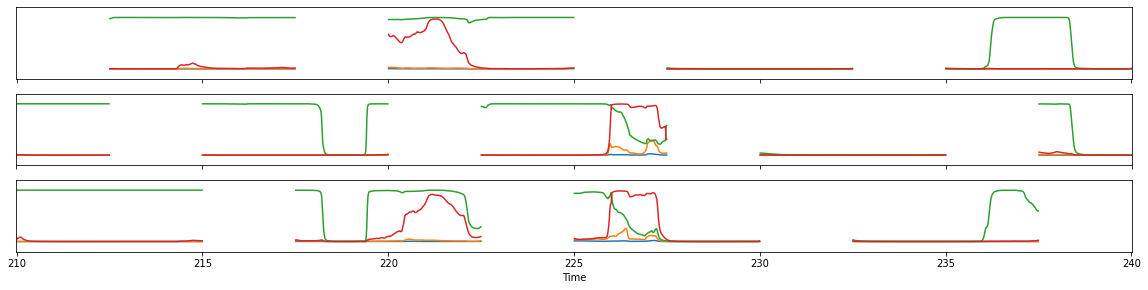

In [ ]:
spk_probability = Inference(pretrained, step=2.5)(test_file)
spk_probability

A perfect output would look like that:

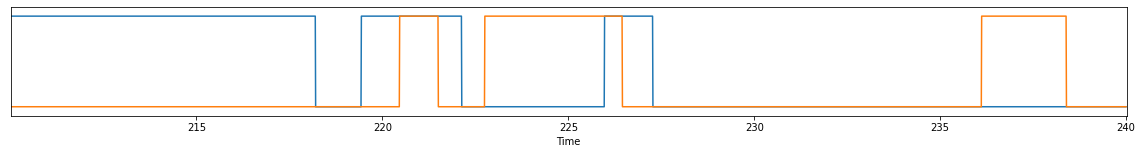

In [ ]:
test_file["annotation"].discretize(notebook.crop, resolution=0.010)

We are going to fine-tune this pretrained model on the AMI dataset:

In [ ]:
from pyannote.audio.tasks import Segmentation
seg_task = Segmentation(ami, duration=5.0, max_num_speakers=4)

To check that fine-tuning was actually helpful, we need to evaluate the performance of the pretrained model, and compute the average local diarization error rate on a 5s window sliding over the whole test set. To do so, we need to create a helper function:

In [ ]:
def test(model, protocol, subset="test"):
    from pyannote.audio.utils.signal import binarize
    from pyannote.audio.utils.metric import DiscreteDiarizationErrorRate
    from pyannote.audio.pipelines.utils import get_devices

    (device,) = get_devices(needs=1)
    metric = DiscreteDiarizationErrorRate()
    files = list(getattr(protocol, subset)())

    inference = Inference(model, device=device)

    for file in files:
        reference = file["annotation"]
        hypothesis = binarize(inference(file))
        uem = file["annotated"]
        _ = metric(reference, hypothesis, uem=uem)
        
    return abs(metric)

We can then evaluate the model and see its local DER:

In [ ]:
der_pretrained = test(model=pretrained, protocol=ami, subset="test")
print(f"Local DER (pretrained) = {der_pretrained * 100:.1f}%")

Local DER (pretrained) = 18.3%


Next, we prepare the model for fine-tuning, simply by overriding its `task` attribute...

In [ ]:
from copy import deepcopy
finetuned = deepcopy(pretrained)
finetuned.task = seg_task

... and we train it (for just one epoch)

In [ ]:
trainer = pl.Trainer(gpus=1, max_epochs=1)
trainer.fit(finetuned)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params | In sizes       | Out sizes                                     
-------------------------------------------------------------------------------------------------------------------
0 | sincnet           | SincNet    | 42.6 K | [32, 1, 80000] | [32, 60, 293]                                 
1 | lstm              | LSTM       | 1.4 M  | [32, 293, 60]  | [[32, 293, 256], [[8, 32, 128], [8, 32, 128]]]
2 | linear            | ModuleList | 49.4 K | ?              | ?                                             
3 | classifier        | Linear     | 516    | [32, 293, 128] | [32, 293, 4]                                  
4 | activation        | Sigmoid    | 0      | [32, 293, 4]   | [32, 293, 4]                                  
5 | validation_metric | AUROC      | 0      | ?              | ?        

We now evaluate the performance of the fine-tuned model...

In [ ]:
der_finetuned = test(model=finetuned, protocol=ami, subset="test")
print(f"Local DER (finetuned) = {der_finetuned * 100:.1f}%")

Local DER (finetuned) = 17.5%


... to confirm that it actually improved its performance on the AMI test set.


## Transfer learning

What if you are only interested in detecting overlapped speech regions? 

Looking at the output of the `pyannote/segmentation` model, it seems that it would be a good starting point for training such a dedicated model:

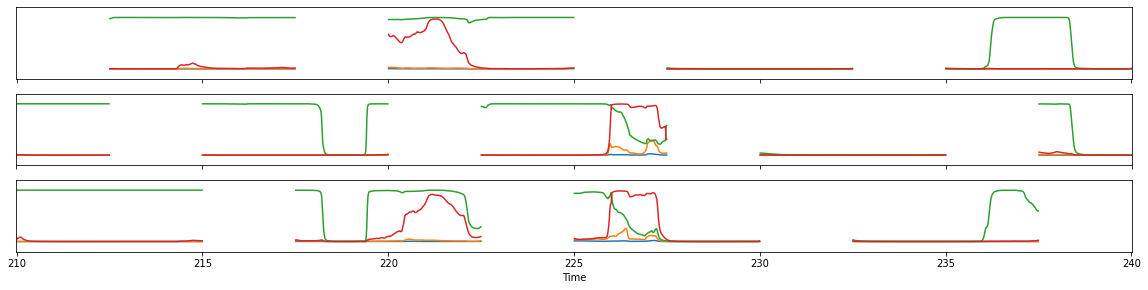

In [ ]:

Inference('pyannote/segmentation', use_auth_token=True, step=2.5)(test_file)

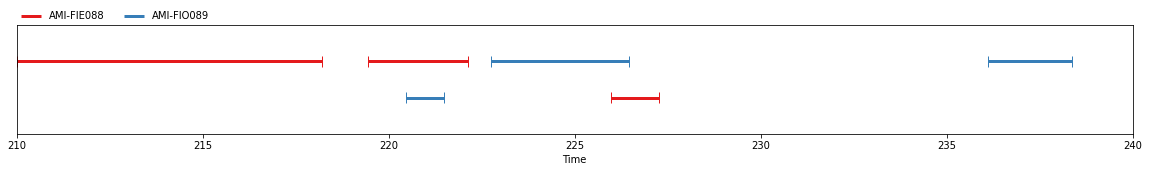

In [ ]:
test_file["annotation"]

Let's update the model so that it specifically addresses overlapped speech detection.  
This is achieved very simply by updating the `task` attribute...

In [ ]:
from pyannote.audio.tasks import OverlappedSpeechDetection
osd_task = OverlappedSpeechDetection(ami, duration=2.0)

osd_model = Model.from_pretrained("pyannote/segmentation", use_auth_token=True)
osd_model.task = osd_task

... optionally freeezing a bunch of layers...

In [ ]:
osd_model.freeze_up_to('lstm')

['sincnet',
 'sincnet.wav_norm1d',
 'sincnet.conv1d',
 'sincnet.conv1d.0',
 'sincnet.conv1d.0.filterbank',
 'sincnet.conv1d.1',
 'sincnet.conv1d.2',
 'sincnet.pool1d',
 'sincnet.pool1d.0',
 'sincnet.pool1d.1',
 'sincnet.pool1d.2',
 'sincnet.norm1d',
 'sincnet.norm1d.0',
 'sincnet.norm1d.1',
 'sincnet.norm1d.2',
 'lstm']

... and training it:

In [ ]:
trainer = pl.Trainer(gpus=1, max_epochs=1)
trainer.fit(osd_model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params | In sizes       | Out sizes                                     
-------------------------------------------------------------------------------------------------------------------
0 | sincnet           | SincNet    | 42.6 K | [32, 1, 32000] | [32, 60, 115]                                 
1 | lstm              | LSTM       | 1.4 M  | [32, 115, 60]  | [[32, 115, 256], [[8, 32, 128], [8, 32, 128]]]
2 | linear            | ModuleList | 49.4 K | ?              | ?                                             
3 | classifier        | Linear     | 129    | [32, 115, 128] | [32, 115, 1]                                  
4 | activation        | Sigmoid    | 0      | [32, 115, 1]   | [32, 115, 1]                                  
5 | validation_metric | AUROC      | 0      | ?              | ?        

Et voilà! A brand new overlapped speech detection model!

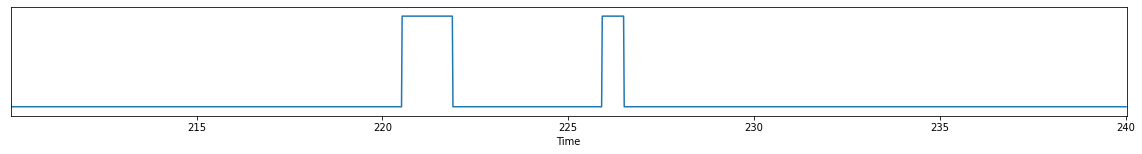

In [ ]:
from pyannote.audio.utils.signal import binarize
binarize(Inference(osd_model)(test_file))

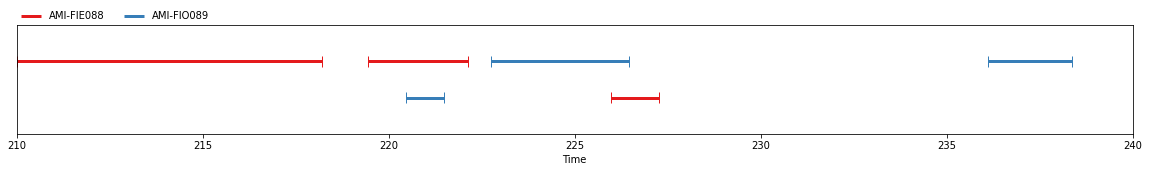

In [ ]:
test_file["annotation"]

## Going further

This tutorial only scratched the surface of the training API.

Every task supports an `augmentation` parameter for training with data augmentation via [`torch-audiomentations`](https://github.com/asteroid-team/torch-audiomentations) library:

```python
from torch_audiomentations import AddBackgroundNoise
augmentation = AddBackgroundNoise("/path/to/background/noise/directory")
vad_task = VoiceActivityDetection(ami, augmentation=augmentation)
```

We also benefit from all the nice things [`pytorch-lightning`](ttps://pytorch-lightning.readthedocs.io) has to offer (like multi-gpu training, for instance).

```python
trainer = Trainer(gpus=4, strategy='ddp')
trainer.fit(model)
```

Default optimizer (`Adam` with default parameters) is automatically set up for you.  
Customizing optimizer (and scheduler) requires overriding [`model.configure_optimizers`](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.core.lightning.html#pytorch_lightning.core.lightning.LightningModule.configure_optimizers) method:

```python
from types import MethodType
from torch.optim import SGD
from torch.optim.lr_scheduler import ExponentialLR
def configure_optimizers(self):
    return {"optimizer": SGD(self.parameters()),
            "lr_scheduler": ExponentialLR(optimizer, 0.9)}
model.configure_optimizers = MethodType(configure_optimizers, model)
trainer.fit(model)
```